# Anomaly Detection in Python

This notebook covers the material in the AI+ Training course on an introduction to fraud and anomaly detection. It goes through three main modules as follows:

1. Data Preparation
2. Probability and Statistical Approaches
3. Machine Learning Approaches

The following code loads all the necessary packages and libraries for the analysis.

Detection: figuring out previous issues/frauds

Prevention: predicting how it will look like even if different from previous examples

In [1]:
pip install pandas

Note: you may need to restart the kernel to use updated packages.


In [9]:
!pip install tensorflow==2.9.0

Could not install packages due to an EnvironmentError: [WinError 5] Access is denied: 'c:\\programdata\\anaconda3\\lib\\site-packages\\absl_py-0.13.0.dist-info\\direct_url.json'
Consider using the `--user` option or check the permissions.




  Found existing installation: tensorflow-estimator 2.7.0
    Uninstalling tensorflow-estimator-2.7.0:
      Successfully uninstalled tensorflow-estimator-2.7.0
  Found existing installation: flatbuffers 2.0
    Uninstalling flatbuffers-2.0:
      Successfully uninstalled flatbuffers-2.0
  Found existing installation: absl-py 0.13.0
    Uninstalling absl-py-0.13.0:


In [8]:
!pip install scipy==1.5.0

tensorflow 2.2.0 has requirement scipy==1.4.1; python_version >= "3", but you'll have scipy 1.5.0 which is incompatible.
tensorflow 2.2.0 has requirement tensorflow-estimator<2.3.0,>=2.2.0, but you'll have tensorflow-estimator 2.7.0 which is incompatible.
Could not install packages due to an EnvironmentError: [WinError 5] Access is denied: 'C:\\ProgramData\\Anaconda3\\Lib\\site-packages\\scipy\\conftest.py'
Consider using the `--user` option or check the permissions.




  Found existing installation: scipy 1.4.1
    Uninstalling scipy-1.4.1:
      Successfully uninstalled scipy-1.4.1
  Rolling back uninstall of scipy


In [2]:
!pip install distfit

In [3]:
!pip install benfordslaw

  Running setup.py bdist_wheel for wget: started
  Running setup.py bdist_wheel for wget: finished with status 'done'
  Stored in directory: C:\Users\abbas\AppData\Local\pip\Cache\wheels\40\15\30\7d8f7cea2902b4db79e3fea550d7d7b85ecb27ef992b618f3f
Successfully built wget


In [4]:
!pip install matplotlib

In [5]:
!pip install sklearn

In [6]:
import pandas as pd
import datetime as dt
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms
from distfit import distfit
from benfordslaw import benfordslaw
from sklearn.covariance import MinCovDet
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import OneClassSVM

ImportError: cannot import name 'moduleTNC' from 'scipy.optimize' (C:\Users\abbas\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\__init__.py)

## Data Preparation

This module details the area of data preparation for good anomaly detection. Anomaly detection is only as good as the data and the features that you have to detect anomalies. This module covers four main concepts in data preparation:

1. Feature Engineering
2. Recency and Frequency
3. Periodic Means
4. Categorical Feature Engineering

Let's load the dataset we will be working with.

In [8]:
ins = pd.read_csv("transactions_ins.csv")

ins.head()
# Reward_R: reason for reward
# Reward_A: quantity of reward
# it's good to have reported income vs real income to gain trust

,Date,Cust_ID,Transaction,Type,Reward_R,Reward_A,Cov_Limit,Income
0,9/10/1977,PSX000100006,IN,T,NaN,NaN,50000.0,61000.0
1,12/31/2005,PSX000100006,CL,T,NaN,NaN,50000.0,61000.0
2,1/17/2006,PSX000100006,RE,T,265.0,50000.0,NaN,NaN
3,12/15/1998,PSX000100010,IN,T,NaN,NaN,100000.0,29000.0
4,6/7/1961,PSX000100013,IN,V,NaN,NaN,100000.0,48000.0


In [9]:
ins.describe(include='all')

,Date,Cust_ID,Transaction,Type,Reward_R,Reward_A,Cov_Limit,Income
count,278877,278877,278877,278877,44488.000000,4.448800e+04,2.343890e+05,234389.000000
unique,23165,121191,4,3,NaN,NaN,NaN,NaN
top,9/15/2010,PSX000704539,IN,T,NaN,NaN,NaN,NaN
freq,44,21,121191,139958,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,315.732602,2.247246e+05,2.057786e+05,53363.899594
std,NaN,NaN,NaN,NaN,126.895957,2.284420e+05,1.984034e+05,25199.547677
min,NaN,NaN,NaN,NaN,100.000000,0.000000e+00,5.000000e+04,15000.000000
25%,NaN,NaN,NaN,NaN,207.000000,1.000000e+05,1.000000e+05,34422.000000
50%,NaN,NaN,NaN,NaN,314.000000,1.500000e+05,1.500000e+05,50000.000000
75%,NaN,NaN,NaN,NaN,421.000000,3.000000e+05,2.500000e+05,68026.000000


In [10]:
ins['Date'] = pd.to_datetime(ins['Date'])

### Feature Engineering

The concept of feature engineering is vitally important to anomaly detection. In my personal experience, the best features aren't just automatically generated by a computer, but thought up by a knowledgable individual working on the problem. 

We are going to role up the transactions to be one per individual. Here are some basic features when rolling up our transactions that might be important when discovering fraud:
- Final income
- Time between claim and reward
- Coverage limit to income ratio at claim
- time between policy start date and claim

Think of some more of your own!

Let's create final income.

In [11]:
ins_income = ins[ins['Transaction'] == 'CL']

ins_income = ins_income[['Cust_ID', 'Cov_Limit', 'Income']]

ins_income.head(n = 10)

,Cust_ID,Cov_Limit,Income
1,PSX000100006,50000.0,61000.0
5,PSX000100013,100000.0,48000.0
14,PSX000100073,100000.0,35000.0
18,PSX000100081,50000.0,69000.0
24,PSX000100122,150000.0,105000.0
31,PSX000100146,100000.0,38000.0
50,PSX000100231,400000.0,79155.0
56,PSX000100236,250000.0,54738.0
62,PSX000100286,150000.0,95973.0
67,PSX00010030,350000.0,37725.0


Now, let's create time in between claim and reward.

In [12]:
ins_time = ins[(ins['Transaction'] == 'CL') | (ins['Transaction'] == 'RE')]

ins_time.head(n = 10)

,Date,Cust_ID,Transaction,Type,Reward_R,Reward_A,Cov_Limit,Income
1,2005-12-31,PSX000100006,CL,T,NaN,NaN,50000.0,61000.0
2,2006-01-17,PSX000100006,RE,T,265.0,50000.0,NaN,NaN
5,2001-06-12,PSX000100013,CL,V,NaN,NaN,100000.0,48000.0
6,2001-07-11,PSX000100013,RE,V,265.0,100000.0,NaN,NaN
14,2004-01-21,PSX000100073,CL,V,NaN,NaN,100000.0,35000.0
15,2004-02-14,PSX000100073,RE,V,450.0,100000.0,NaN,NaN
18,2009-06-28,PSX000100081,CL,T,NaN,NaN,50000.0,69000.0
19,2009-07-26,PSX000100081,RE,T,543.0,0.0,NaN,NaN
24,1991-08-23,PSX000100122,CL,T,NaN,NaN,150000.0,105000.0
25,1991-09-08,PSX000100122,RE,T,200.0,150000.0,NaN,NaN


In [13]:
ins_time['diff'] = ins_time['Date'] - ins_time['Date'].shift(1)

ins_time.head(n = 10)

,Date,Cust_ID,Transaction,Type,Reward_R,Reward_A,Cov_Limit,Income,diff
1,2005-12-31,PSX000100006,CL,T,NaN,NaN,50000.0,61000.0,NaT
2,2006-01-17,PSX000100006,RE,T,265.0,50000.0,NaN,NaN,17 days
5,2001-06-12,PSX000100013,CL,V,NaN,NaN,100000.0,48000.0,-1680 days
6,2001-07-11,PSX000100013,RE,V,265.0,100000.0,NaN,NaN,29 days
14,2004-01-21,PSX000100073,CL,V,NaN,NaN,100000.0,35000.0,924 days
15,2004-02-14,PSX000100073,RE,V,450.0,100000.0,NaN,NaN,24 days
18,2009-06-28,PSX000100081,CL,T,NaN,NaN,50000.0,69000.0,1961 days
19,2009-07-26,PSX000100081,RE,T,543.0,0.0,NaN,NaN,28 days
24,1991-08-23,PSX000100122,CL,T,NaN,NaN,150000.0,105000.0,-6547 days
25,1991-09-08,PSX000100122,RE,T,200.0,150000.0,NaN,NaN,16 days


In [14]:
ins_time = ins_time[ins_time['Transaction'] == 'RE']

ins_time = ins_time[['Date', 'Cust_ID', 'Type', 'Reward_R', 'Reward_A', 'diff']]

ins_time.head(n = 10)

,Date,Cust_ID,Type,Reward_R,Reward_A,diff
2,2006-01-17,PSX000100006,T,265.0,50000.0,17 days
6,2001-07-11,PSX000100013,V,265.0,100000.0,29 days
15,2004-02-14,PSX000100073,V,450.0,100000.0,24 days
19,2009-07-26,PSX000100081,T,543.0,0.0,28 days
25,1991-09-08,PSX000100122,T,200.0,150000.0,16 days
32,2009-04-21,PSX000100146,T,275.0,100000.0,20 days
51,2008-05-05,PSX000100231,V,405.0,400000.0,25 days
57,1970-10-06,PSX000100236,T,469.0,250000.0,24 days
63,2003-03-20,PSX000100286,V,337.0,150000.0,22 days
68,1980-01-09,PSX00010030,T,377.0,350000.0,23 days


Lastly, let's combine our datasets from above and create coverage limit to income ratio.

In [15]:
ins_feat = ins_time.merge(ins_income)

ins_feat.head(n = 10)

,Date,Cust_ID,Type,Reward_R,Reward_A,diff,Cov_Limit,Income
0,2006-01-17,PSX000100006,T,265.0,50000.0,17 days,50000.0,61000.0
1,2001-07-11,PSX000100013,V,265.0,100000.0,29 days,100000.0,48000.0
2,2004-02-14,PSX000100073,V,450.0,100000.0,24 days,100000.0,35000.0
3,2009-07-26,PSX000100081,T,543.0,0.0,28 days,50000.0,69000.0
4,1991-09-08,PSX000100122,T,200.0,150000.0,16 days,150000.0,105000.0
5,2009-04-21,PSX000100146,T,275.0,100000.0,20 days,100000.0,38000.0
6,2008-05-05,PSX000100231,V,405.0,400000.0,25 days,400000.0,79155.0
7,1970-10-06,PSX000100236,T,469.0,250000.0,24 days,250000.0,54738.0
8,2003-03-20,PSX000100286,V,337.0,150000.0,22 days,150000.0,95973.0
9,1980-01-09,PSX00010030,T,377.0,350000.0,23 days,350000.0,37725.0


In [16]:
ins_feat['Cov_Income_Ratio'] = ins_feat['Cov_Limit'] / ins_feat['Income']

ins_feat.head(n = 10)

,Date,Cust_ID,Type,Reward_R,Reward_A,diff,Cov_Limit,Income,Cov_Income_Ratio
0,2006-01-17,PSX000100006,T,265.0,50000.0,17 days,50000.0,61000.0,0.819672
1,2001-07-11,PSX000100013,V,265.0,100000.0,29 days,100000.0,48000.0,2.083333
2,2004-02-14,PSX000100073,V,450.0,100000.0,24 days,100000.0,35000.0,2.857143
3,2009-07-26,PSX000100081,T,543.0,0.0,28 days,50000.0,69000.0,0.724638
4,1991-09-08,PSX000100122,T,200.0,150000.0,16 days,150000.0,105000.0,1.428571
5,2009-04-21,PSX000100146,T,275.0,100000.0,20 days,100000.0,38000.0,2.631579
6,2008-05-05,PSX000100231,V,405.0,400000.0,25 days,400000.0,79155.0,5.053376
7,1970-10-06,PSX000100236,T,469.0,250000.0,24 days,250000.0,54738.0,4.567211
8,2003-03-20,PSX000100286,V,337.0,150000.0,22 days,150000.0,95973.0,1.562940
9,1980-01-09,PSX00010030,T,377.0,350000.0,23 days,350000.0,37725.0,9.277667


### Recency and Frequency

We will look at recency and frequency one at a time. Let's start with recency. For ease of application, let's use all the differences in time for all customers to build our recency exponential distribution instead of building one per customer.

Specifically, we will look at recency of changes in policy.

In [17]:
ins_rec = ins

ins_rec['diff'] = ins_rec['Date'] - ins_rec['Date'].shift(1)
# 'CH' means change
ins_rec = ins_rec[ins_rec['Transaction'] == 'CH']

ins_rec.head(n = 10)

,Date,Cust_ID,Transaction,Type,Reward_R,Reward_A,Cov_Limit,Income,diff
11,1986-04-16,PSX000100058,CH,T,NaN,NaN,250000.0,130280.0,3958 days
29,1997-08-30,PSX000100140,CH,W,NaN,NaN,150000.0,87073.0,2440 days
35,2007-10-26,PSX000100167,CH,V,NaN,NaN,300000.0,63041.0,7455 days
36,2008-11-20,PSX000100167,CH,V,NaN,NaN,350000.0,66722.0,391 days
37,2010-10-03,PSX000100167,CH,V,NaN,NaN,550000.0,68743.0,682 days
39,1996-11-17,PSX000100168,CH,W,NaN,NaN,350000.0,68371.0,3160 days
40,1998-03-13,PSX000100168,CH,W,NaN,NaN,500000.0,82691.0,481 days
46,2012-03-02,PSX000100217,CH,V,NaN,NaN,300000.0,43560.0,8420 days
48,1983-04-06,PSX000100231,CH,V,NaN,NaN,300000.0,75657.0,3412 days
49,2006-09-16,PSX000100231,CH,V,NaN,NaN,400000.0,79155.0,8564 days


In [18]:
# compute 1/gamma for this data set (on difference in days)
# ideal way is to compute gamma for every single customer
# here it makes sense to have one gamma, because we don't have too many transactions
exp_rec = st.distributions.expon.fit(ins_rec['diff'].dt.days)

print(exp_rec)

(0.0, 3937.351099374079)


In [19]:
ins_rec['rec'] = np.exp(-(1/exp_rec[1])*(ins_rec['diff'].dt.days))

ins_rec.head(n = 10)

,Date,Cust_ID,Transaction,Type,Reward_R,Reward_A,Cov_Limit,Income,diff,rec
11,1986-04-16,PSX000100058,CH,T,NaN,NaN,250000.0,130280.0,3958 days,0.365955
29,1997-08-30,PSX000100140,CH,W,NaN,NaN,150000.0,87073.0,2440 days,0.538103
35,2007-10-26,PSX000100167,CH,V,NaN,NaN,300000.0,63041.0,7455 days,0.150558
36,2008-11-20,PSX000100167,CH,V,NaN,NaN,350000.0,66722.0,391 days,0.905466
37,2010-10-03,PSX000100167,CH,V,NaN,NaN,550000.0,68743.0,682 days,0.840959
39,1996-11-17,PSX000100168,CH,W,NaN,NaN,350000.0,68371.0,3160 days,0.448176
40,1998-03-13,PSX000100168,CH,W,NaN,NaN,500000.0,82691.0,481 days,0.885004
46,2012-03-02,PSX000100217,CH,V,NaN,NaN,300000.0,43560.0,8420 days,0.117832
48,1983-04-06,PSX000100231,CH,V,NaN,NaN,300000.0,75657.0,3412 days,0.420390
49,2006-09-16,PSX000100231,CH,V,NaN,NaN,400000.0,79155.0,8564 days,0.113601


In [20]:
ins_rec = ins_rec.groupby('Cust_ID', as_index=False)['rec'].mean()

ins_rec.head(n = 10)

,Cust_ID,rec
0,PSX000100058,0.365955
1,PSX000100140,0.538103
2,PSX000100167,0.632328
3,PSX000100168,0.666590
4,PSX000100217,0.117832
5,PSX000100231,0.266995
6,PSX000100234,0.208820
7,PSX000100236,0.469855
8,PSX000100286,0.453212
9,PSX00010030,0.692811


For our data, frequency of changes in policy might also be a flag of fraud. 

In [21]:
ins_changes = ins

ins_changes['T_CH'] = pd.get_dummies(ins_changes['Transaction'], prefix='T')['T_CH']

ins_changes = ins_changes.groupby('Cust_ID', as_index=False)['T_CH'].sum()

ins_changes.head(n = 10)

,Cust_ID,T_CH
0,PSX000100006,0
1,PSX000100010,0
2,PSX000100013,0
3,PSX000100016,0
4,PSX000100027,0
5,PSX000100037,0
6,PSX000100058,1
7,PSX00010006,0
8,PSX000100073,0
9,PSX000100077,0


Let's combine these recency and frequency features into our features dataset.

In [22]:
ins_feat = ins_feat.merge(ins_rec)

ins_feat.head(n = 10)

,Date,Cust_ID,Type,Reward_R,Reward_A,diff,Cov_Limit,Income,Cov_Income_Ratio,rec
0,2008-05-05,PSX000100231,V,405.0,400000.0,25 days,400000.0,79155.0,5.053376,0.266995
1,1970-10-06,PSX000100236,T,469.0,250000.0,24 days,250000.0,54738.0,4.567211,0.469855
2,2003-03-20,PSX000100286,V,337.0,150000.0,22 days,150000.0,95973.0,1.562940,0.453212
3,1980-01-09,PSX00010030,T,377.0,350000.0,23 days,350000.0,37725.0,9.277667,0.692811
4,1994-12-26,PSX000100314,W,144.0,750000.0,24 days,750000.0,72816.0,10.299934,0.626925
5,2007-01-28,PSX000100337,W,445.0,400000.0,11 days,400000.0,114879.0,3.481924,0.868747
6,1991-06-11,PSX000100470,T,386.0,800000.0,22 days,800000.0,74437.0,10.747343,0.695067
7,2011-02-08,PSX000100555,T,519.0,0.0,23 days,650000.0,33238.0,19.555930,0.438743
8,2005-09-27,PSX000100585,V,264.0,300000.0,23 days,300000.0,26998.0,11.111934,0.078684
9,1990-01-24,PSX000100611,T,298.0,300000.0,25 days,300000.0,25930.0,11.569610,0.057281


In [23]:
ins_feat = ins_feat.merge(ins_changes)

ins_feat.head(n = 10)

,Date,Cust_ID,Type,Reward_R,Reward_A,diff,Cov_Limit,Income,Cov_Income_Ratio,rec,T_CH
0,2008-05-05,PSX000100231,V,405.0,400000.0,25 days,400000.0,79155.0,5.053376,0.266995,2
1,1970-10-06,PSX000100236,T,469.0,250000.0,24 days,250000.0,54738.0,4.567211,0.469855,1
2,2003-03-20,PSX000100286,V,337.0,150000.0,22 days,150000.0,95973.0,1.562940,0.453212,1
3,1980-01-09,PSX00010030,T,377.0,350000.0,23 days,350000.0,37725.0,9.277667,0.692811,1
4,1994-12-26,PSX000100314,W,144.0,750000.0,24 days,750000.0,72816.0,10.299934,0.626925,4
5,2007-01-28,PSX000100337,W,445.0,400000.0,11 days,400000.0,114879.0,3.481924,0.868747,1
6,1991-06-11,PSX000100470,T,386.0,800000.0,22 days,800000.0,74437.0,10.747343,0.695067,4
7,2011-02-08,PSX000100555,T,519.0,0.0,23 days,650000.0,33238.0,19.555930,0.438743,3
8,2005-09-27,PSX000100585,V,264.0,300000.0,23 days,300000.0,26998.0,11.111934,0.078684,1
9,1990-01-24,PSX000100611,T,298.0,300000.0,25 days,300000.0,25930.0,11.569610,0.057281,1


### Periodic Mean

Python isn't as well created for this feature as compared to R.

### Categorical Feature Engineering

### see slide 66 (important for which approach to take while dealing with categorical var.)
Feature engineering doesn't stop with just continuous variables in transactional data. We need to account for categorical features as well.

In our data, the reward reason (Reward_R) variable is categorical. It has numerical representations for reasons of passing that are given on the life insurance policy. Some of these reasons are approved - life insurance policy is paid out. However, not all reasons of passing are covered so the policy isn't paid out in those scenarios.

In [24]:
len(set(ins_feat['Reward_R']))

480

Instead of having 480 possible categories, let combine these into two groups - approved and rejected reasons - based on the reward amount. If the reward amount was 0, then the reason was not covered by the policy.

In [25]:
ins_feat['Reward_Y'] = ins_feat['Reward_A'].apply(lambda x: 'Y' if x > 0 else 'N')

ins_feat.head(n = 10)

,Date,Cust_ID,Type,Reward_R,Reward_A,diff,Cov_Limit,Income,Cov_Income_Ratio,rec,T_CH,Reward_Y
0,2008-05-05,PSX000100231,V,405.0,400000.0,25 days,400000.0,79155.0,5.053376,0.266995,2,Y
1,1970-10-06,PSX000100236,T,469.0,250000.0,24 days,250000.0,54738.0,4.567211,0.469855,1,Y
2,2003-03-20,PSX000100286,V,337.0,150000.0,22 days,150000.0,95973.0,1.562940,0.453212,1,Y
3,1980-01-09,PSX00010030,T,377.0,350000.0,23 days,350000.0,37725.0,9.277667,0.692811,1,Y
4,1994-12-26,PSX000100314,W,144.0,750000.0,24 days,750000.0,72816.0,10.299934,0.626925,4,Y
5,2007-01-28,PSX000100337,W,445.0,400000.0,11 days,400000.0,114879.0,3.481924,0.868747,1,Y
6,1991-06-11,PSX000100470,T,386.0,800000.0,22 days,800000.0,74437.0,10.747343,0.695067,4,Y
7,2011-02-08,PSX000100555,T,519.0,0.0,23 days,650000.0,33238.0,19.555930,0.438743,3,N
8,2005-09-27,PSX000100585,V,264.0,300000.0,23 days,300000.0,26998.0,11.111934,0.078684,1,Y
9,1990-01-24,PSX000100611,T,298.0,300000.0,25 days,300000.0,25930.0,11.569610,0.057281,1,Y


## Probability and Statistical Approaches

This module details the area of probability and statistical approaches to anomaly detection. Classical probability and statistical approaches to anomaly detection are a great foundation and are still widely used and useful in detecting anomalies. This module covers four main concepts in probability and statistical approaches to anomaly detection:

1. Benford's Law
2. Z-scores and Robust Z-scores
3. IQR Rule and It's Adjustment
4. Mahalanobis Distances

### Benford's Law

We don't have addresses in our data so it makes it hard to see if someone applied for a life insurance policy using fake information. However, let's see how we would apply that to data. 

In [26]:
bl = benfordslaw(alpha=0.05)

results = bl.fit(ins_feat['Income'])

bl.plot

[benfordslaw] >Analyzing digit position: [1]
[benfordslaw] >[chi2] Anomaly detected! P=0, Tstat=9126.26


<bound method benfordslaw.plot of <benfordslaw.benfordslaw.benfordslaw object at 0x7f7d6fca4970>>

### Z-Scores and Robust Z-scores

We want to evaluate if we have an observation far away from "normal" in our coverage to income ratio at time of claim. We are looking for really large life insurance coverage limits when income is not very high - a large ratio between the two.

Text(0.5, 1.0, 'Coverage to Income Ratio')

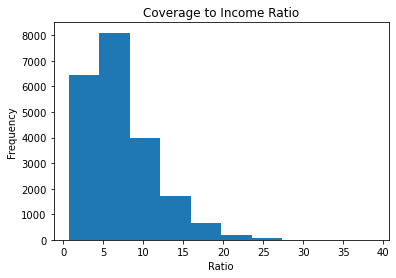

In [27]:
plt.hist(ins_feat['Cov_Income_Ratio'])
plt.xlabel('Ratio')
plt.ylabel('Frequency')
plt.title('Coverage to Income Ratio')

Text(0.5, 1.0, 'Coverage to Income Ratio Z-Score')

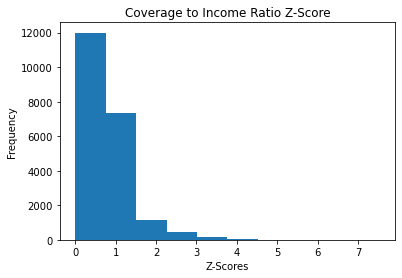

In [28]:
ins_feat['Z_Cov_Income_Ratio'] = abs((ins_feat['Cov_Income_Ratio'] - ins_feat['Cov_Income_Ratio'].mean())/ins_feat['Cov_Income_Ratio'].std())

plt.hist(ins_feat['Z_Cov_Income_Ratio'])
plt.xlabel('Z-Scores')
plt.ylabel('Frequency')
plt.title('Coverage to Income Ratio Z-Score')

In [29]:
len(ins_feat[ins_feat['Z_Cov_Income_Ratio'] > 3])

256

Let's switch to using the robust z-score calculation instead.

Text(0.5, 1.0, 'Coverage to Income Ratio Robust Z-Score')

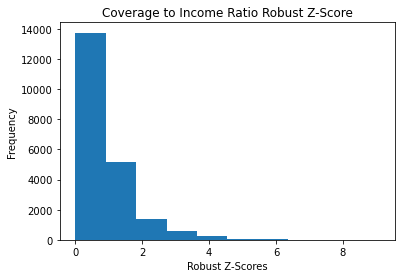

In [30]:
ins_feat['RZ_Cov_Income_Ratio'] = abs((ins_feat['Cov_Income_Ratio'] - ins_feat['Cov_Income_Ratio'].median())/st.median_absolute_deviation(ins_feat['Cov_Income_Ratio']))

plt.hist(ins_feat['RZ_Cov_Income_Ratio'])
plt.xlabel('Robust Z-Scores')
plt.ylabel('Frequency')
plt.title('Coverage to Income Ratio Robust Z-Score')

In [31]:
len(ins_feat[ins_feat['RZ_Cov_Income_Ratio'] > 3])

665

### IQR Rule

Another univariate approach to looking for outliers is the IQR Rule. However, the IQR Rule really works best for symmetric distributions. For our coverage limit to income ratio variable we know this isn't symmetric based on our above plots 

{'whiskers': [<matplotlib.lines.Line2D at 0x7f7d74442c40>,
 'caps': [<matplotlib.lines.Line2D at 0x7f7d74451340>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f7d744428e0>],
 'medians': [<matplotlib.lines.Line2D at 0x7f7d74451a00>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f7d74451d60>],
 'means': []}

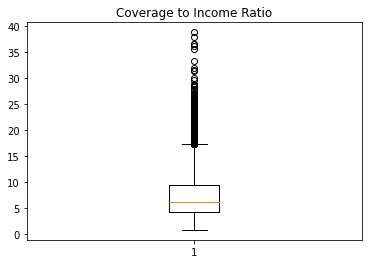

In [32]:
fig1, ax1 = plt.subplots()
ax1.set_title('Coverage to Income Ratio')
ax1.boxplot(ins_feat['Cov_Income_Ratio'])

### Mahalanobis Distances

When looking at two or more variables at the same time, we need to account for multiple dimensions. Mahalanobis distances are a multivariate version of the z-score. 

Let compare the two variables of average recency of changes in policies and frequency of these changes.

Text(0.5, 1.0, 'Income vs. Coverage to Income Ratio')

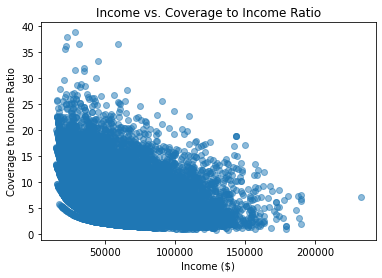

In [33]:
plt.scatter(x = ins_feat['Income'], y = ins_feat['Cov_Income_Ratio'], alpha = 0.5)
plt.xlabel('Income ($)')
plt.ylabel('Coverage to Income Ratio')
plt.title('Income vs. Coverage to Income Ratio')

In [34]:
def confidence_ellipse(x, y, ax, n_std=2.0, facecolor='none', **kwargs):
    """
    Create a plot of the covariance confidence ellipse of *x* and *y*.

    Parameters
    ----------
    x, y : array-like, shape (n, )
        Input data.

    ax : matplotlib.axes.Axes
        The axes object to draw the ellipse into.

    n_std : float
        The number of standard deviations to determine the ellipse's radiuses.

    **kwargs
        Forwarded to `~matplotlib.patches.Ellipse`

    Returns
    -------
    matplotlib.patches.Ellipse
    """
    if x.size != y.size:
        raise ValueError("x and y must be the same size")

    cov = np.cov(x, y)
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    # Using a special case to obtain the eigenvalues of this
    # two-dimensionl dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2,
                      facecolor=facecolor, **kwargs)

    # Calculating the stdandard deviation of x from
    # the squareroot of the variance and multiplying
    # with the given number of standard deviations.
    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = np.mean(x)

    # calculating the stdandard deviation of y ...
    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = np.mean(y)

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)

    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)

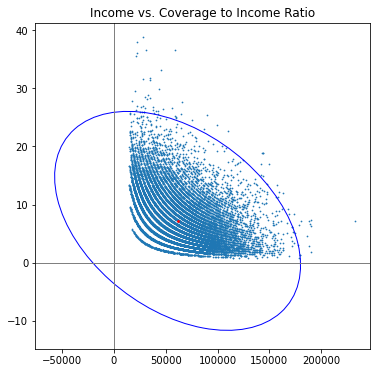

In [35]:
fig, ax_nstd = plt.subplots(figsize=(6, 6))

mu = ins_feat['Income'].mean(), ins_feat['Cov_Income_Ratio'].mean()

ax_nstd.axvline(c='grey', lw=1)
ax_nstd.axhline(c='grey', lw=1)

x = ins_feat['Income']
y = ins_feat['Cov_Income_Ratio']
ax_nstd.scatter(x, y, s=0.5)

confidence_ellipse(x, y, ax_nstd, n_std=4.5, edgecolor='blue', linestyle='-')

ax_nstd.scatter(mu[0], mu[1], c='red', s=3)
ax_nstd.set_title('Income vs. Coverage to Income Ratio')
plt.show()

In [36]:
d = {'Income': ins_feat['Income'], 'CIRatio': ins_feat['Cov_Income_Ratio']}
df = pd.DataFrame(data=d)

covMCD = MinCovDet(random_state=0).fit(df)

In [37]:
def confidence_ellipse_r(x, y, ax, n_std=4.5, facecolor='none', **kwargs):
    """
    Create a plot of the covariance confidence ellipse of *x* and *y*.

    Parameters
    ----------
    x, y : array-like, shape (n, )
        Input data.

    ax : matplotlib.axes.Axes
        The axes object to draw the ellipse into.

    n_std : float
        The number of standard deviations to determine the ellipse's radiuses.

    **kwargs
        Forwarded to `~matplotlib.patches.Ellipse`

    Returns
    -------
    matplotlib.patches.Ellipse
    """
    if x.size != y.size:
        raise ValueError("x and y must be the same size")
        
    d = {'X': x, 'Y': y}
    df = pd.DataFrame(data=d)

    covMCD = MinCovDet(random_state=0).fit(df)

    cov = covMCD.covariance_
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    # Using a special case to obtain the eigenvalues of this
    # two-dimensionl dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2,
                      facecolor=facecolor, **kwargs)

    # Calculating the stdandard deviation of x from
    # the squareroot of the variance and multiplying
    # with the given number of standard deviations.
    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = covMCD.location_[0]

    # calculating the stdandard deviation of y ...
    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = covMCD.location_[1]

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)

    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)

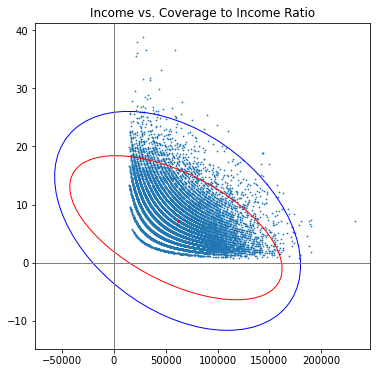

In [38]:
fig, ax_nstd = plt.subplots(figsize=(6, 6))

mu = ins_feat['Income'].mean(), ins_feat['Cov_Income_Ratio'].mean()

ax_nstd.axvline(c='grey', lw=1)
ax_nstd.axhline(c='grey', lw=1)

x = ins_feat['Income']
y = ins_feat['Cov_Income_Ratio']
ax_nstd.scatter(x, y, s=0.5)

confidence_ellipse(x, y, ax_nstd, n_std=4.5, edgecolor='blue', linestyle='-')
confidence_ellipse_r(x, y, ax_nstd, n_std=4.5, edgecolor='red', linestyle='-')

ax_nstd.scatter(mu[0], mu[1], c='red', s=3)
ax_nstd.set_title('Income vs. Coverage to Income Ratio')
plt.show()

## Machine Learning Approaches

This module details the area of machine learning approaches to anomaly detection. With the enhancements and creation of machine learning approaches to modeling, these same techniques form the foundation of more advanced anomaly detection methods. This module covers five main concepts in machine learning approaches to anomaly detection:

1. k-Nearest Neighbors (k-NN)
2. Local Outlier Factor (LOF)
3. Isolation Forests
4. Classifier-Adjusted Density Estimation (CADE)
5. One-Class Support Vector Machines (SVM)

### k-Nearest Neighbors

Instead of looking at more statistical approaches, we can directly look at the average distance each point is from its k-nearest neighbors.

In [39]:
d = {'Income': ins_feat['Income'], 'CIRatio': ins_feat['Cov_Income_Ratio']}
df = pd.DataFrame(data=d)

nbrs = NearestNeighbors(n_neighbors=6, algorithm='ball_tree').fit(df)
distances, indices = nbrs.kneighbors(df)

print(distances)
print(indices)

[[ 0.          4.04961388  5.34713401  8.38975717 10.19246983 12.14878186]
 [ 0.          2.70871573  3.00000001  3.13603931  3.39233355  4.39724912]
 [ 0.          1.          2.88843158  4.29455322  5.30497282  5.89657472]
 ...
 [ 0.          5.08984714  5.52077368  7.09738077  7.69405959  8.33554128]
 [ 0.          4.30845506  5.24932517 13.38925486 14.00000066 16.08019347]
 [ 0.          2.16945724  3.00000001 11.032153   15.09411524 16.02200207]]
[[    0 15116  9724  8013  5633  2584]
 [    1   143  9713  5729  2818  1418]
 [    2  9032  7286    63 18569 16271]
 ...
 [21174 17232  1949 17440 10451 11524]
 [21175  3914 11010 21123 14081 12644]
 [21176 15612 13368 19944 11778 12727]]


In [40]:
df.to_csv('')

FileNotFoundError: [Errno 2] No such file or directory: ''

Text(0.5, 1.0, 'Income vs. Coverage to Income Ratio')

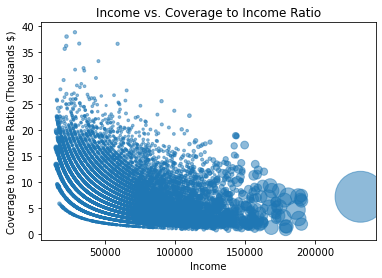

In [41]:
df['nndist'] = np.mean(distances, axis = 1)

plt.scatter(x = ins_feat['Income'], y = ins_feat['Cov_Income_Ratio'], alpha = 0.5, s = (df['nndist'])**(0.75))
plt.xlabel('Income')
plt.ylabel('Coverage to Income Ratio (Thousands $)')
plt.title('Income vs. Coverage to Income Ratio')

### Local Outlier Factor (LOF)

Let's examine more local outliers.

Text(0.5, 1.0, 'Income vs. Coverage to Income Ratio')

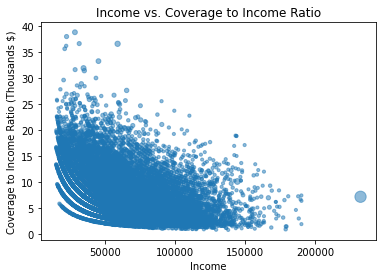

In [42]:
d = {'Income': ins_feat['Income'], 'CIRatio': ins_feat['Cov_Income_Ratio']}
df = pd.DataFrame(data=d)

lof = LocalOutlierFactor(n_neighbors=6)
lof.fit_predict(df)

df['lof'] = -lof.negative_outlier_factor_

plt.scatter(x = ins_feat['Income'], y = ins_feat['Cov_Income_Ratio'], alpha = 0.5, s = df['lof']*10)
plt.xlabel('Income')
plt.ylabel('Coverage to Income Ratio (Thousands $)')
plt.title('Income vs. Coverage to Income Ratio')

(array([2.1114e+04, 6.1000e+01, 1.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([  8.49989338,  20.36860736,  32.23732133,  44.10603531,
         55.97474928,  67.84346326,  79.71217723,  91.58089121,
        103.44960518, 115.31831916, 127.18703313]),
 <BarContainer object of 10 artists>)

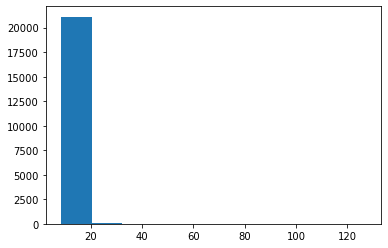

In [43]:
plt.hist(df['lof']*10)

### Isolation Forest

Instead of distance based measures, now we switch to tree based approaches.

Text(0.5, 1.0, 'Income vs. Coverage to Income Ratio')

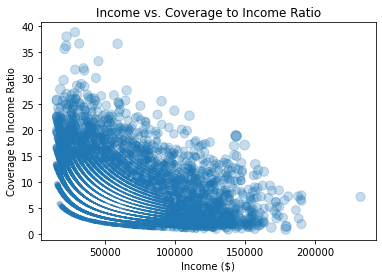

In [44]:
d = {'Income': ins_feat['Income'], 'CIRatio': ins_feat['Cov_Income_Ratio']}
df = pd.DataFrame(data=d)

isofor = IsolationForest(random_state=0, n_estimators = 500).fit(df)
iso = -isofor.score_samples(df)

df['iso'] = iso
df['iso2'] = ((iso - np.min(iso))/(np.max(iso) - np.min(iso))*10)**2

plt.scatter(x = ins_feat['Income'], y = ins_feat['Cov_Income_Ratio'], alpha = 0.25, s = df['iso2'])
plt.xlabel('Income ($)')
plt.ylabel('Coverage to Income Ratio')
plt.title('Income vs. Coverage to Income Ratio')

(array([8754., 5147., 2823., 1897.,  967.,  660.,  406.,  259.,  200.,
          64.]),
 array([0.40468006, 0.43800817, 0.47133627, 0.50466438, 0.53799248,
        0.57132059, 0.6046487 , 0.6379768 , 0.67130491, 0.70463301,
        0.73796112]),
 <BarContainer object of 10 artists>)

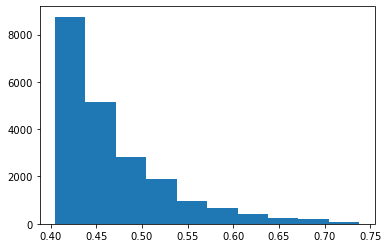

In [45]:
plt.hist(df['iso'])

### Classifier-Adjusted Density Estimation (CADE)

Let's now finish off with more density based approaches to anomaly detection. Unfortunately, since CADE is so new we need to write it ourselves.

In [46]:
d = {'Income': ins_feat['Income'], 'CIRatio': ins_feat['Cov_Income_Ratio'], 'Target': 0}
df = pd.DataFrame(data=d)

df.head(n = 10)

,Income,CIRatio,Target
0,79155.0,5.053376,0
1,54738.0,4.567211,0
2,95973.0,1.562940,0
3,37725.0,9.277667,0
4,72816.0,10.299934,0
5,114879.0,3.481924,0
6,74437.0,10.747343,0
7,33238.0,19.555930,0
8,26998.0,11.111934,0
9,25930.0,11.569610,0


In [47]:
d_fake = {'Income': np.random.uniform(np.min(ins_feat['Income']), np.max(ins_feat['Income']), size = len(ins_feat['Income'])), 
          'CIRatio': np.random.uniform(np.min(ins_feat['Cov_Income_Ratio']), np.max(ins_feat['Cov_Income_Ratio']), 
                                       size = len(ins_feat['Cov_Income_Ratio'])),
          'Target': 1}
df_fake = pd.DataFrame(data=d_fake)

df_fake.head(n = 10)

,Income,CIRatio,Target
0,121936.654868,9.688916,1
1,199403.359349,24.928826,1
2,163401.555633,31.743299,1
3,227341.782812,13.217792,1
4,100808.920063,5.920532,1
5,167624.942915,34.387604,1
6,149707.004746,31.944607,1
7,48885.875874,5.072027,1
8,151131.541549,5.579647,1
9,56428.000551,35.143823,1


In [48]:
df_comb = df.append(df_fake, ignore_index=True)

print(df_comb)

              Income    CIRatio  Target
0       79155.000000   5.053376       0
1       54738.000000   4.567211       0
2       95973.000000   1.562940       0
3       37725.000000   9.277667       0
4       72816.000000  10.299934       0
...              ...        ...     ...
42349   81821.369958  29.575041       1
42350   31445.519208  13.128792       1
42351  172537.890740  24.504326       1
42352   93678.133421  34.707993       1
42353  214399.442545   8.635041       1

[42354 rows x 3 columns]


In [49]:
model = RandomForestClassifier()
model.fit(df_comb[['Income', 'CIRatio']], df_comb['Target'])

df['pred'] = model.predict_proba(df[['Income', 'CIRatio']])[:,1]
df['odds'] = df['pred'] / (1 - df['pred'])

df.head(n = 10)

,Income,CIRatio,Target,pred,odds
0,79155.0,5.053376,0,0.00,0.000000
1,54738.0,4.567211,0,0.03,0.030928
2,95973.0,1.562940,0,0.00,0.000000
3,37725.0,9.277667,0,0.01,0.010101
4,72816.0,10.299934,0,0.11,0.123596
5,114879.0,3.481924,0,0.06,0.063830
6,74437.0,10.747343,0,0.10,0.111111
7,33238.0,19.555930,0,0.33,0.492537
8,26998.0,11.111934,0,0.02,0.020408
9,25930.0,11.569610,0,0.01,0.010101


(array([1.8579e+04, 1.3460e+03, 5.3500e+02, 3.0300e+02, 2.4200e+02,
        1.3400e+02, 3.4000e+01, 2.0000e+00, 1.0000e+00, 1.0000e+00]),
 array([  0.        ,  11.73913043,  23.47826087,  35.2173913 ,
         46.95652174,  58.69565217,  70.43478261,  82.17391304,
         93.91304348, 105.65217391, 117.39130435]),
 <BarContainer object of 10 artists>)

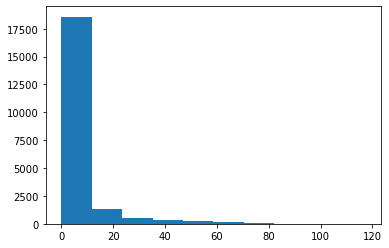

In [50]:
plt.hist(df['odds']*100)

Text(0.5, 1.0, 'Income vs. Coverage to Income Ratio')

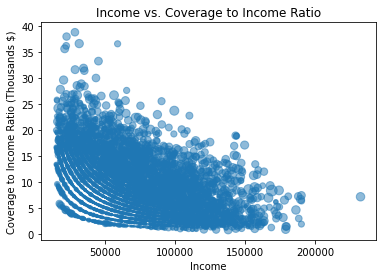

In [51]:
plt.scatter(x = ins_feat['Income'], y = ins_feat['Cov_Income_Ratio'], alpha = 0.5, s = df['odds']*100)
plt.xlabel('Income')
plt.ylabel('Coverage to Income Ratio (Thousands $)')
plt.title('Income vs. Coverage to Income Ratio')

### One-Class Support Vector Machines

Lastly, let's look at the support vector machine approach.

In [52]:
d = {'Income': ins_feat['Income'], 'CIRatio': ins_feat['Cov_Income_Ratio']}
df = pd.DataFrame(data=d)

svm = OneClassSVM(gamma=0.00001, nu = 0.05).fit_predict(df)

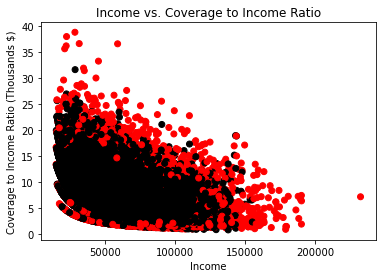

In [53]:
df['svm'] = svm

fig, ax = plt.subplots()

colors = {-1:'red', 1:'black'}

ax.scatter(ins_feat['Income'], ins_feat['Cov_Income_Ratio'], c = df['svm'].map(colors))
plt.xlabel('Income')
plt.ylabel('Coverage to Income Ratio (Thousands $)')
plt.title('Income vs. Coverage to Income Ratio')
plt.show()

In [54]:
d = {'Income': ins_feat['Income'], 'CIRatio': ins_feat['Cov_Income_Ratio'], 'Target': 0}
df = pd.DataFrame(data=d)

d_fake = {'Income': np.random.uniform(np.min(ins_feat['Income']), np.max(ins_feat['Income']), size = len(ins_feat['Income'])), 
          'CIRatio': np.random.uniform(np.min(ins_feat['Cov_Income_Ratio']), np.max(ins_feat['Cov_Income_Ratio']), 
                                       size = len(ins_feat['Cov_Income_Ratio'])),
          'Target': 1}
df_fake = pd.DataFrame(data=d_fake)

df_comb = df.append(df_fake, ignore_index=True)

model = RandomForestClassifier()
model.fit(df_comb[['Income', 'CIRatio']], df_comb['Target'])

df['pred'] = model.predict_proba(df[['Income', 'CIRatio']])[:,1]